<a href="https://colab.research.google.com/github/maritnorli/IFCB_CNN_Classify/blob/main/CNN_transferlearning_IFCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Connect to cuda and Mount Drive manually in Colab!!!***

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Copy files from drive to colab to work in colab

In [47]:
## Import the colab libraries and set up paths
from google.colab import drive
import os

## copy files from drive to colab
import shutil
# Specify the path to your "going_modular" folder in Google Drive
drive_path = "/content/drive/MyDrive/IFCB/going_modular"


# List files in the "going_modular" folder
files = os.listdir(drive_path)

# Copy each file individually to the /content directory
for file in files:
    src = os.path.join(drive_path, file)
    dst = os.path.join("/content", file)
    try:
        shutil.copy(src, dst)
    except Exception as e:
        print(f"Failed to copy {file}: {e}")

# wait a minute or so before it pops up

## 01. Prepare data

In [48]:
from pathlib import Path

# Set data paths
data_path = Path("/content/drive/MyDrive/IFCB/data/")
image_path = Path("/content/drive/MyDrive/IFCB/data/IFCB_test_train")

# Setup Dirs
train_dir = image_path / "Train"
test_dir = image_path / "Test"


In [49]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Now try importing modules directly from the copied drive files
try:
    import data_setup
    import engine

except ModuleNotFoundError as e:
    print(f"Failed to import modules: {e}")


In [50]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [51]:
#Create transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [52]:
# Create training and testing dataloaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b32cc7e2ad0>,
 ['Chaetoceros_decipiens_118',
  'Guinardia_delicatula_095',
  'Tripos_muelleri_008'])

### Get and prepare a pretrained model


In [53]:
# New method of creating a pretrained model (torchvision v0.13+)
#weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # ".DEFAULT" = best available weights
model = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model #uncoment to output (its very long)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False

In [55]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

#Recreate the classifier layer and seed it to the target device

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # feature vector coming in
              out_features=output_shape,
              bias=True)).to(device) # how many classes do we have?

#model.classifier

### Train model

In [56]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [57]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results (as model_0_results(still model, just name update for later comparison))
model_0_results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.8563 | train_acc: 0.6905 | test_loss: 0.5773 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.4929 | train_acc: 0.9162 | test_loss: 0.4684 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.2696 | train_acc: 0.9742 | test_loss: 0.3820 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.1889 | train_acc: 0.9831 | test_loss: 0.2751 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.1488 | train_acc: 0.9955 | test_loss: 0.2112 | test_acc: 1.0000
[INFO] Total training time: 12.333 seconds


### Make predictions on the entire test dataset with the model

In [58]:
from tqdm.auto import tqdm
# Make predictions on the entire test dataset
test_preds = []
model.eval()
print(f"Length of test dataloader is {len(test_dataloader)} batches")

with torch.inference_mode():
  #loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # PAss the data through the model
    test_logits = model(X)

    #convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    #convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the cpu
test_preds = torch.cat(test_preds).cpu()
test_preds

Length of test dataloader is 2 batches


  0%|          | 0/2 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### Make a cunfusion matrix with the test preds and the truth labels


In [59]:
#get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Need the following libraries to make a cinfusion matrix
* torchmetrics
* mlxtend

In [60]:
# See if torchmetrics is installed and if not, install...
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1
mlxtend version: 0.23.1


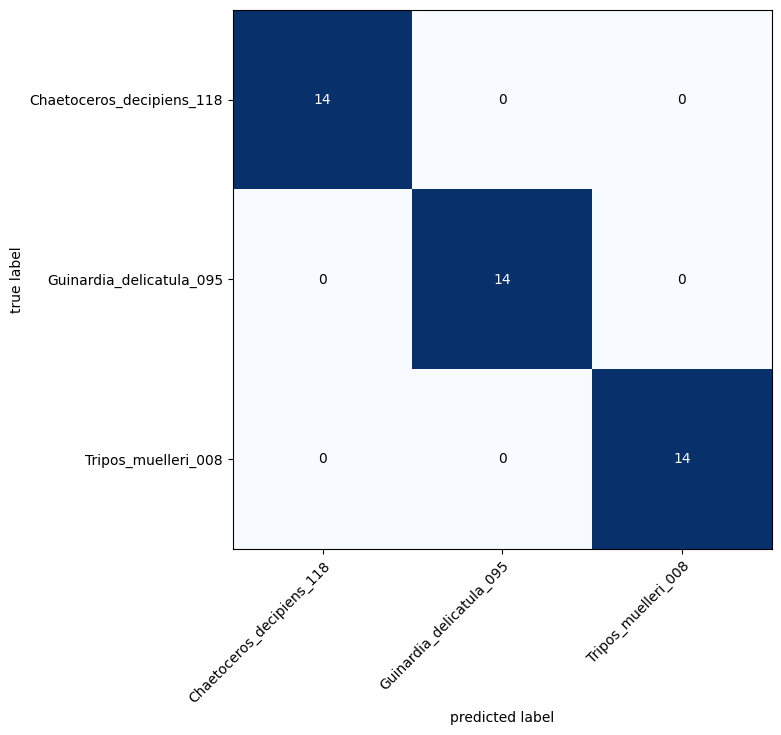

In [61]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_names,
    figsize=(10, 7)
)



### Code for plotting the most wrong images

* Create a dataframe with sample, label, prediction, pred prob
*sort dataframe by correct(does label == prediction)
*sort dataframe by pred prob(descending)
*plot the top 5 most wrong

In [62]:
# Create a dataframe with sample, label, prediction, pred probs


# Get all test data paths
# get a list of all the samples (paths)

from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.png"))
test_labels = [path.parent.stem for path in test_data_paths]

# create a function to return a list of dictionaries with sample, label prediction, pred probs
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    #Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    #Get prediction and prediction probablility
    from PIL import Image #open image
    img = Image.open(path)
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit=model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch. argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      #Make sure everything in dictionary is on cpu
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item() #.item() to not have it as a tensor
      pred_dict["pred_class"] = pred_class

    # does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    print(pred_dict)

    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model,
                                 transform=simple_transform,
                                 class_names=class_names,
                                 device=device)
test_pred_dicts[:5]



  0%|          | 0/42 [00:00<?, ?it/s]

{'image_path': PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_118/D20230505T131754_IFCB139_00015.png'), 'class_name': 'Chaetoceros_decipiens_118', 'pred_prob': 0.7563225626945496, 'pred_class': 'Chaetoceros_decipiens_118', 'correct': True}
{'image_path': PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_118/D20230505T113231_IFCB139_00009.png'), 'class_name': 'Chaetoceros_decipiens_118', 'pred_prob': 0.7604790329933167, 'pred_class': 'Chaetoceros_decipiens_118', 'correct': True}
{'image_path': PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_118/D20230505T121441_IFCB139_00013.png'), 'class_name': 'Chaetoceros_decipiens_118', 'pred_prob': 0.8222172856330872, 'pred_class': 'Chaetoceros_decipiens_118', 'correct': True}
{'image_path': PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_118/D20230505T105022_IFCB139_00012.png'), 'class_name': 'C

[{'image_path': PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_118/D20230505T131754_IFCB139_00015.png'),
  'class_name': 'Chaetoceros_decipiens_118',
  'pred_prob': 0.7563225626945496,
  'pred_class': 'Chaetoceros_decipiens_118',
  'correct': True},
 {'image_path': PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_118/D20230505T113231_IFCB139_00009.png'),
  'class_name': 'Chaetoceros_decipiens_118',
  'pred_prob': 0.7604790329933167,
  'pred_class': 'Chaetoceros_decipiens_118',
  'correct': True},
 {'image_path': PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_118/D20230505T121441_IFCB139_00013.png'),
  'class_name': 'Chaetoceros_decipiens_118',
  'pred_prob': 0.8222172856330872,
  'pred_class': 'Chaetoceros_decipiens_118',
  'correct': True},
 {'image_path': PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_118/D20230505T105022_IFCB13

In [63]:
#Turn the test_pred_dicts into a dataframe
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
#test_pred_df.head()
top_5_most_wrong = test_pred_df.sort_values(["correct", "pred_prob"], ascending=[True, False]).head() #Correct ascending, pred_prob descending
#top_5_most_right = test_pred_df.sort_values(["correct", "pred_prob"], ascending=[False, True]) #Correct ascending, pred_prob descending
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
7,/content/drive/MyDrive/IFCB/data/IFCB_test_tra...,Chaetoceros_decipiens_118,0.983412,Chaetoceros_decipiens_118,True
6,/content/drive/MyDrive/IFCB/data/IFCB_test_tra...,Chaetoceros_decipiens_118,0.964025,Chaetoceros_decipiens_118,True
12,/content/drive/MyDrive/IFCB/data/IFCB_test_tra...,Chaetoceros_decipiens_118,0.951921,Chaetoceros_decipiens_118,True
41,/content/drive/MyDrive/IFCB/data/IFCB_test_tra...,Tripos_muelleri_008,0.934173,Tripos_muelleri_008,True
10,/content/drive/MyDrive/IFCB/data/IFCB_test_tra...,Chaetoceros_decipiens_118,0.911285,Chaetoceros_decipiens_118,True


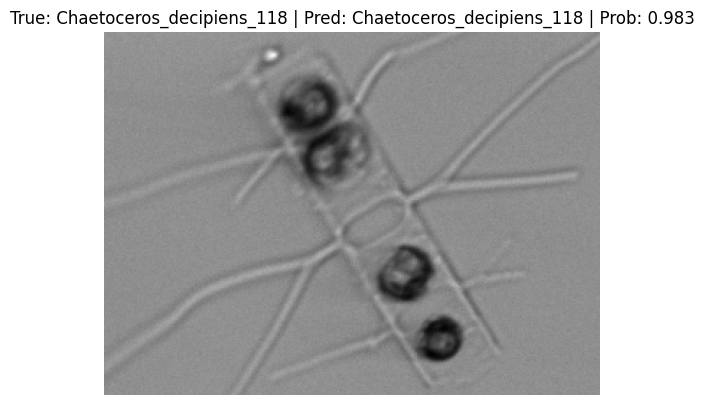

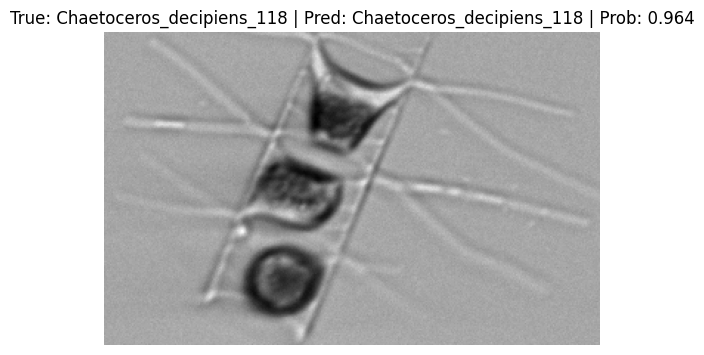

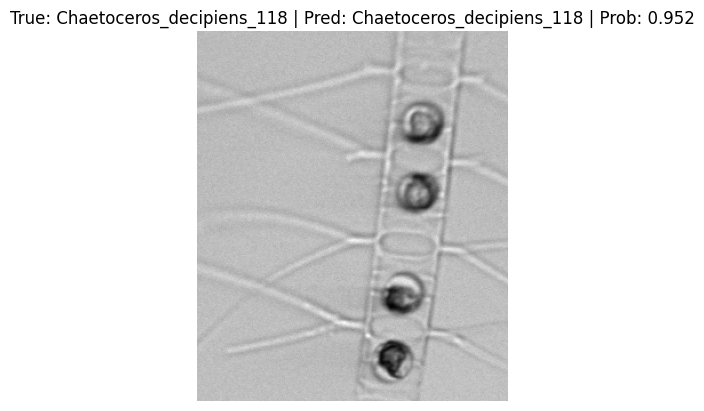

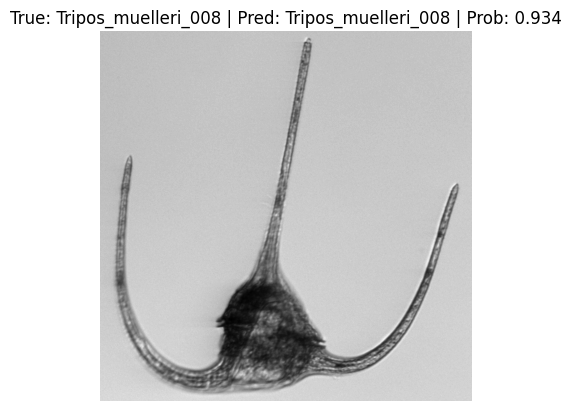

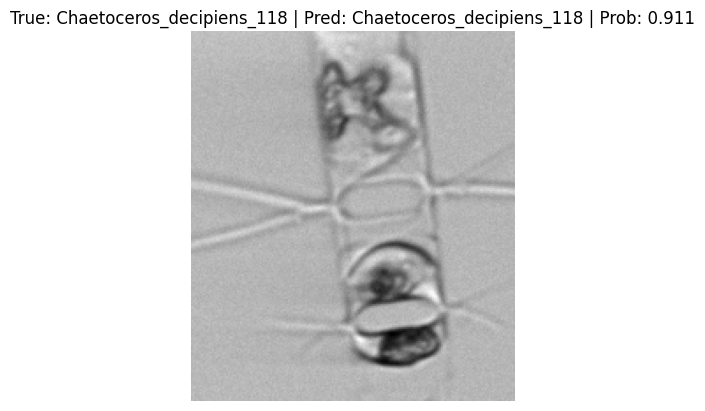

In [64]:
# Plot the top most wrong images
for row in top_5_most_wrong.iterrows():
  row=row[1]
  image_path=row[0]
  true_label = row[1]
  pred_prob= row[2]
  pred_class = row[3]
  # plot the image and various details
  img = torchvision.io.read_image(str(image_path))
  plt.figure()
  plt.imshow(img.permute(1,2,0), cmap='gray') # matplotlib height width colorchannels)
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False);


### Tip: to troubleshhot model print images that are wrongly classified and with a high probability

###  1. Predict on a different image that is one of the classes
###  2. Predict on an image that is not one of the classes

In [65]:

## copy files from drive to colab
#import shutil
# Specify the path to your "going_modular" folder in Google Drive
#drive_path = "/content/drive/MyDrive/IFCB/going_modular"


# List files in the "going_modular" folder
#files = os.listdir(drive_path)

# Copy each file individually to the /content directory
#for file in files:
#    src = os.path.join(drive_path, file)
#    dst = os.path.join("/content", file)
#    try:
#        shutil.copy(src, dst)
#    except Exception as e:
#        print(f"Failed to copy {file}: {e}")

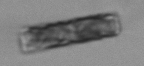

In [66]:
from PIL import Image
Image.open("/content/drive/MyDrive/D20220109T202913_IFCB139_00004.png")


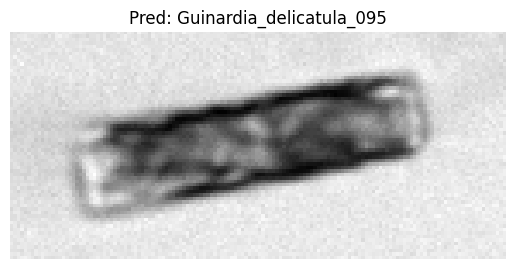

In [67]:
# 1. Different image but one of the classes
from PIL import Image

def pred_and_plot(image_path, model, transform, class_names, device=device):
  # Open image
  image = Image.open(image_path)

  #transform image
  transformed_image = transform(image)

#Pred on image
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_label = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)

  #plot image and pred
  plt.figure()
  #plt.imshow(img.permute(1,2,0), cmap='gray')
  plt.imshow(image, cmap="gray")
  plt.title(f"Pred: {class_names[pred_label]}")
  plt.axis(False);

pred_and_plot(image_path="/content/drive/MyDrive/D20220109T202913_IFCB139_00004.png",
              model=model,
              transform=simple_transform,
              class_names=class_names)

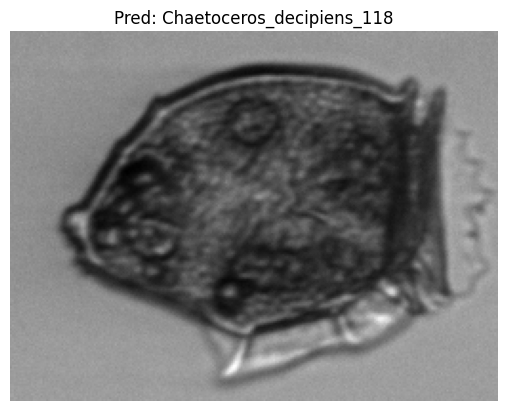

In [68]:
# 1. Different image and not one of the classes

pred_and_plot(image_path="/content/drive/MyDrive/D20220314T182147_IFCB139_00063.png",
              model=model,
              transform=simple_transform,
              class_names=class_names)

### <--This is supposed to be wrong :-)

## Train a model_1 for 10 epochs

In [69]:
# Make a model
import torchvision
from torch import nn
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

#freeze base layers
for param in model_1.features.parameters():
  param.requires_grad = False

#Change classification head
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2),
    #Here: we want to keep the tensor size of infeatures in efficientnet as 1280,
    #but change the length of out features from 1000 to 3 (class outputs)
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)
model_1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [70]:
#inspect model
#summary(model_1,
#        input_size=[32, 3, 244, 244],
#        col_names=["input_size", "output_size", "trainable"])
#input size batch size, color channels, height, width)
#based on what model you use as the pretrained 244 and 244 will differ


In [71]:
#Create a loss and optimizer
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [72]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.8345 | train_acc: 0.7123 | test_loss: 0.6823 | test_acc: 0.9844
Epoch: 2 | train_loss: 0.4783 | train_acc: 0.9330 | test_loss: 0.4887 | test_acc: 0.9844
Epoch: 3 | train_loss: 0.2618 | train_acc: 0.9742 | test_loss: 0.3834 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.1766 | train_acc: 0.9787 | test_loss: 0.2610 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.1384 | train_acc: 0.9955 | test_loss: 0.1913 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.1295 | train_acc: 0.9911 | test_loss: 0.1486 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.1132 | train_acc: 0.9955 | test_loss: 0.1149 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0815 | train_acc: 1.0000 | test_loss: 0.0916 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0865 | train_acc: 0.9911 | test_loss: 0.0700 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0767 | train_acc: 0.9955 | test_loss: 0.0546 | test_acc: 1.0000
[INFO] Total training time: 36.084 seconds


###har lagt til helper_functions i drive, men det må lastes ned til colab

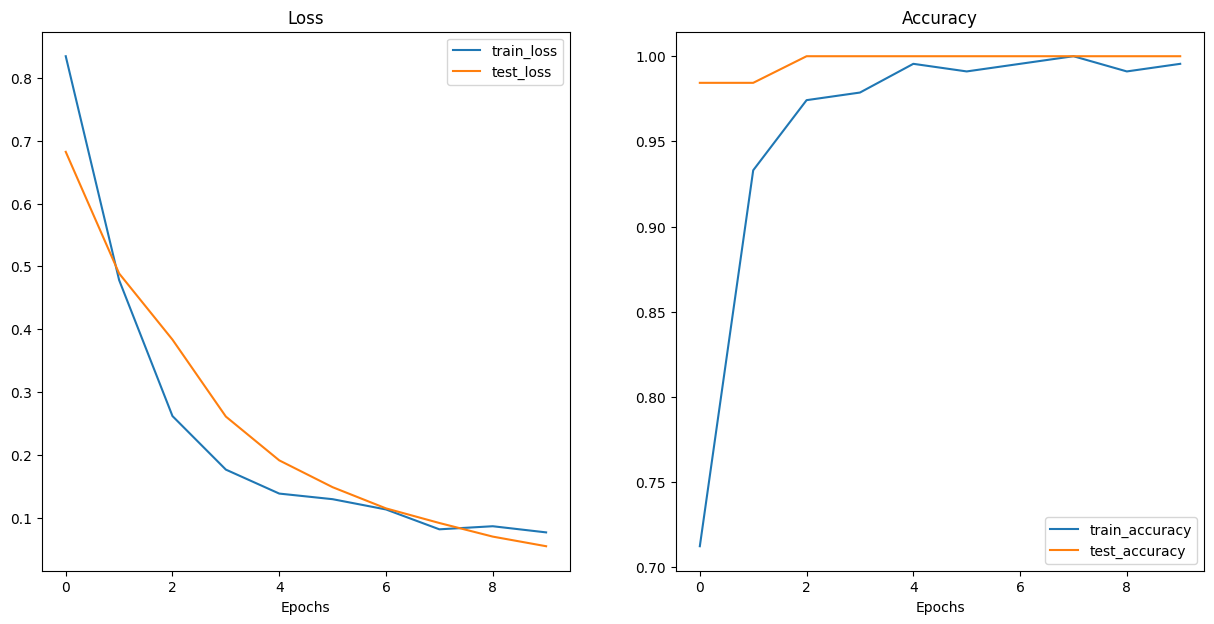

In [73]:
# Plot the loss curves
from helper_functions import plot_loss_curves
#Plot the loss urves of model_1
plot_loss_curves(model_1_results)


Overfitting(coursedata): Data augmentation or a learning rate decay(lovering the learning rate over time) can help prevent overfitting

In [74]:
#Can be used to compare, but must edit the notebook for that
#max(model_0_results["test_acc"]), min(model_0_results["test_loss"])
#max(model_1_results["test_acc"]), min(model_1_results["test_loss"])


### Try a different model from torchvision.models
* must change the size of classifier for our output classes

Check out models here
https://pytorch.org/vision/stable/models.html

In [75]:
# Create a transform to transform the data
from torchvision import transforms, models
effnet_b2_transform = transforms.Compose([
    transforms.Resize((288,288)), #effnet_b2 takes images of size 288, 288 -
    # https://pytorch.org/vision/0.17/models/generated/torchvision.models.efficientnet_b2.html
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [76]:
#check dirs
train_dir, test_dir

(PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Train'),
 PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test'))

In [77]:
# Import the data
train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnet_b2_transform,
                                                                                                 batch_size=32)


In [78]:
# create a new model
model_2 = torchvision.models.efficientnet_b2(pretrained=True).to(device)
model_2

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [79]:
#To find info on freeze the base layers: COPY from end of prev cell results:
#(0): Dropout(p=0.3, inplace=True)
#    (1): Linear(in_features=1408, out_features=1000, bias=True)


In [80]:
# continue creating the new model
import torchvision
from torch import nn
model_2 = torchvision.models.efficientnet_b2(pretrained=True).to(device)

#freeze base layers
#for param in model_2.features.parameters():
for param in model_2.parameters():
  param.requires_grad = False

#Change classification head (to suit our problem)
model_2.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    #Here: we want to keep the tensor size of infeatures in efficientnet as 1280,
    #but change the length of out features from 1000 to 3 (class outputs)
    nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
).to(device)

# Get a summary of model_2
summary(model_2,
        input_size=[32, 3, 288, 288],
        col_names=["input_size", "output_size", "trainable"])



        #google torchinfo TylerYep view model summaries github what to call these
#col_names (Iterable[str]):
#            Specify which columns to show in the output. Currently supported: (
#                "input_size",
#                "output_size",
#                "num_params",
#                "params_percent",
#                "kernel_size",
#                "mult_adds",
#                "trainable",
#

Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 288, 288]         [32, 3]                   Partial
├─Sequential: 1-1                                       [32, 3, 288, 288]         [32, 1408, 9, 9]          False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 288, 288]         [32, 32, 144, 144]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 288, 288]         [32, 32, 144, 144]        False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 144, 144]        [32, 32, 144, 144]        False
│    │    └─SiLU: 3-3                                   [32, 32, 144, 144]        [32, 32, 144, 144]        --
│    └─Sequential: 2-2                                  [32, 32, 144, 144]        [32, 16, 144, 144]        False
│    │    └─MBConv: 3-4                                 [32, 32, 144, 144]        [32

In [81]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

In [82]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                       train_dataloader=train_dataloader_effnet_b2,
                       test_dataloader=test_dataloader_effnet_b2,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9352 | train_acc: 0.5799 | test_loss: 0.7292 | test_acc: 0.8750
Epoch: 2 | train_loss: 0.5367 | train_acc: 0.9286 | test_loss: 0.4948 | test_acc: 0.9688
Epoch: 3 | train_loss: 0.2995 | train_acc: 0.9955 | test_loss: 0.3835 | test_acc: 0.9844
Epoch: 4 | train_loss: 0.2053 | train_acc: 0.9841 | test_loss: 0.2786 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.1469 | train_acc: 0.9911 | test_loss: 0.1889 | test_acc: 1.0000
[INFO] Total training time: 21.586 seconds


In [83]:
#Check results with effnet_b0 10 % of data for 5 epochs
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])


(1.0, 0.21121353656053543)

In [84]:
#Check results with effnet_b0 10 % of data for 10 epochs
max(model_1_results["test_acc"]), min(model_1_results["test_loss"])

(1.0, 0.054646716453135014)

In [85]:
#Check results with effnet_b2 10 % of data for 5 epochs
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(1.0, 0.18890823796391487)